# Part 1: Cleaning and cannonizing DB


Project: Solar Power for Affordable Housing through Computational Design of Low-Cost/High-Efficiency Solar Cells.

Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)

Version: 0.0.1

In [1]:
import sys
import os
SRC_DIR='..'

In [2]:
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

/home/vama/soft/python-tests/introtohpc/notebooks/../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')

### Tools to Cannonize smiles

In [4]:
# from rdkit.Chem import MolFromSmiles as smi2mol
# from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint,GetMorganFingerprintAsBitVect
# from rdkit.DataStructs import ConvertToNumpyArray

from smiutil import CleanSMI
from smiutil import canon_smiles
from smiutil import HardValidSMI
from smiutil import applyMorganFP

# from rdkit.Chem import MolFromSmiles as smi2mol


## Open Database

Our database is expresed a CSV file (spread sheet like). This each row has information of the molecular description of in SMILE format, and optical properties as the wavelenght (lamnda/nm), extinction coefficient, first excitation energy with quantum mechanics, etc.

In [5]:
df = pd.read_csv('../data/extended_db_Zindo_Nov_2019_V5.csv').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent']
Table Shape: (9879, 23)


In [43]:
#df.count()

Unfortunately some of the SMILE that define the molecules are not valid. We have a function called `HardValidSMI` which validate whether the SMILES can be processed. See example

In [54]:
#smi=df['smi_post'].iloc[0]
smi = 'O=C1O[C@H]([C@@H](O)CO)C(O)=C1O'
print(f'Q: Is this {smi} a valid molecule? A: {HardValidSMI(smi)}')

Q: Is this O=C1O[C@H]([C@@H](O)CO)C(O)=C1O a valid molecule? A: False


Remove metals and invalid smiles. Adding a new column `nogood`. Notice that there two SMILES: `smile_pre` and `smile_post`. The `smile_pre` are the SMILES generated directly from the molecules found in the literature, and `smiles_post` are a reduced version with only the active region of the molecule.

In [53]:
df['nogood']=df['smi_pre'].apply(HardValidSMI)
#df=df[df['nogood'] != False]
df['nogoodpost']=df['smi_post'].apply(HardValidSMI)
#df=df[df['nogoodp'] != False]

[16:32:49] WARNING: not removing hydrogen atom without neighbors
[16:32:52] WARNING: not removing hydrogen atom without neighbors


Let's filter the rows with `False` values in `nogood`.

In [55]:
df[df['nogood'] != False]

,smiles,inchikey,fpfail,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),...,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,molp,MolWt,MolWtp,MolWtdiff,gapdft,gapmopac,nogoodpost
1,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,WMBWREPUVVBILR-WIYYLYMNSA-N,True,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5,0.013443,0.7857,-8.0182,4.27854,...,0,0,172,<rdkit.Chem.rdchem.Mol object at 0x7fb625384f20>,458.084911,458.084911,0.000000e+00,8.8039,7.996,True
3,Clc1ccc(OCCn2ccnc2)c(Cl)c1,FLMQUWVILHJCFJ-UHFFFAOYSA-N,True,Clc1ccc(c(c1)Cl)OCCn1cncc1,Clc1ccc(c(c1)Cl)OCCn1cncc1,245.2,0.013209,1.0193,-8.8676,3.86453,...,0,0,84,<rdkit.Chem.rdchem.Mol object at 0x7fb625385150>,256.017018,256.017018,0.000000e+00,9.8869,8.673,True
6,COC(=O)Cc1ccc(OC[C@@H]2CO2)cc1,UGCLEKVSHFQKOD-LLVKDONJSA-N,True,COC(=O)Cc1ccc(cc1)OC[C@H]1OC1,COC(=O)Cc1ccc(cc1)OC[C@H]1OC1,245.9,0.039422,1.5588,-8.4152,2.38065,...,1,1,86,<rdkit.Chem.rdchem.Mol object at 0x7fb625385540>,222.089209,222.089209,0.000000e+00,9.9740,9.076,True
7,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,True,CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C,CN1CCN(CC1)c1c(F)cc2c3c1OCC(n3cc(c2=O)C(=O)O)C,291.8,0.049058,0.0174,-8.3155,10.03869,...,1,1,138,<rdkit.Chem.rdchem.Mol object at 0x7fb6253855b0>,361.143784,361.143784,5.684342e-14,8.3329,7.703,True
8,O=C1CC(=C=N[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[...,GXOAJZBMIZDGCK-TVONUNMFSA-N,True,OC[C@H]1O[C@@H](N=C=C2CC(=O)c3c4c2nc2cc(Cl)ccc...,OC[C@H]1O[C@@H](N=C=C2CC(=O)c3c4c2nc2cc(Cl)ccc...,345.9,0.072536,-0.9850,-8.4437,3.35184,...,1,1,164,<rdkit.Chem.rdchem.Mol object at 0x7fb6253857e0>,455.088413,455.088413,1.136868e-13,7.4587,7.480,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9865,N#Cc1c(N2CCCCC2)cc(-c2ccccc2)c2c1-c1cccnc1CC2,SMURFLRAIWQCMM-UHFFFAOYSA-N,True,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,N#Cc1c(cc(c2c1c1cccnc1CC2)c1ccccc1)N1CCCCC1,291.3,0.038060,-0.0526,-8.4226,3.94833,...,1,1,138,<rdkit.Chem.rdchem.Mol object at 0x7fb624658b30>,365.189198,365.189198,0.000000e+00,8.3700,7.642,True
9866,N#Cc1nn(-c2ccc(Cl)cc2)nc1N1CCCC1,IQLDXBXINQMCHI-UHFFFAOYSA-N,True,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,N#Cc1nn(nc1N1CCCC1)c1ccc(cc1)Cl,294.0,0.631244,0.0838,-8.0247,4.64755,...,1,1,96,<rdkit.Chem.rdchem.Mol object at 0x7fb624658ba0>,273.078123,273.078123,0.000000e+00,8.1085,7.450,True
9867,O=c1nc2n(c3nc(N4CCCCC4)ncc13)CCS2,YTKGZLZRIUJNQI-UHFFFAOYSA-N,True,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,O=c1nc2SCCn2c2c1cnc(n2)N1CCCCC1,277.0,0.004539,0.3888,-8.3370,9.34625,...,1,1,104,<rdkit.Chem.rdchem.Mol object at 0x7fb624658c10>,289.099731,289.099731,0.000000e+00,8.7258,8.218,True
9868,COC(=O)c1cc2ccccc2cc1-c1cc2ccccc2cc1C(=O)N(C)[...,HQYAPNWPDBPXTB-NRFANRHFSA-N,True,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,COC(=O)c1cc2ccccc2cc1c1cc2ccccc2cc1C(=O)N([C@H...,292.7,0.047515,0.1759,-8.0675,2.38643,...,0,1,184,<rdkit.Chem.rdchem.Mol object at 0x7fb624658c80>,479.246044,479.246044,0.000000e+00,8.2434,8.082,True


#### Remove systems without sTDA (disabled)

In [13]:
#df['nostda']=df['lambda_sTDA (nm)'].apply(np.isnan)
#df = df[df.nostda == False]
##df = df[df['lambda_sTDA (nm)'] >0 ]
##df.shape

### Clean up temporal columns

In [14]:
#del df['nogood']
df['smiles'] = df['smi_post'].apply(canon_smiles)
df = df[df['smiles'] != False]
#del df['smi_post']
#df.mask(df.eq('None')).dropna()
#df.head(1)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:35] WARNING: not removing hydrogen atom without neighbors
[15:09:36] WARNING: not removing hydrogen atom without neighbors
[15:09:37] SMILES Parse Error: ring closure 1 duplicates bond between atom 46 and atom 47 for input: 'C(CN1c2cc(ccc2C(=C2C(=O)N(c3c2ccc(c3)c2ccc(cc2)C=C(C(=O)O)C#N)CC(C)CC)C1=O)c1ccc2c(c1)C1C1N2c1ccc(cc1)C)CC'
[15:09:37]

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'smiles']
Table Shape: (9870, 26)


[15:09:37] Explicit valence for atom # 12 C, 5, is greater than permitted


### Move smiles columns front

In [15]:
cols= list(df)
cols.insert(0,cols.pop(cols.index('smiles')))
df=df[cols]
print('Column names: {}'.format(str(df.columns.tolist())))

Column names: ['smiles', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp']


### Save file with cannonized smiles

In [16]:
#df=df[['smiles',]]
df.to_csv('../data/extended_db_Zindo_Nov_2019_V5_cann.csv', index=False, quoting=0)

In [17]:
#max(df.smiles.apply(len))

### Work only with post trimming

In [18]:
df = pd.read_csv('../data/extended_db_Zindo_Nov_2019_V5_cann.csv').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['smiles', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp']
Table Shape: (9870, 26)


In [19]:
df[df['lambda_sTDA (nm)']>0].count()

smiles                 7177
inchikey               7177
smi_pre                7177
smi_post               7177
lambda_sTDA (nm)       7177
f1_sTDA                7177
lumo_dft               7177
homo_dft               7177
dmom_dft (D)           7177
lambda_z (nm)          7177
f1_z                   7177
lumo_z                 7177
homo_z                 7177
dmom_z (D)             7177
lumo_mopac             7177
homo_mopac             7177
dmom_mopac (D)         7177
lambda_tddft (nm)      7177
f1_tddft               7177
lambda_exp_max (nm)    7177
epsilon_exp_max        7177
lambda_exp_min (nm)    7177
epsilon_exp_min        7177
solvent                7177
nogood                 7177
nogoodp                7177
dtype: int64

In [20]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:00] WARNING: not removing hydrogen atom without neighbors
[15:10:01] WARNING: not removing hydrogen atom without neighbors
[15:10:01] WARNING: not removing hydrogen atom without neighbors
[15:10:01] WARNING: not removing hydrogen atom without neighbors
[15:10:01] WARNING: not removing hydrogen atom without neighbors
[15:10:01] WARNING: not r

In [21]:
#dfc.shape[0]
fpfail=[]
#for e in dfc.shape[0]:
for e in range(df.shape[0]):
    try:
        fp = applyMorganFP(df.iloc[e].mol,fptype='count',fp_args={'radius':4, 'nBits':2048})
        fpfail.append(True)
    except:
        fpfail.append(False)
        print(e)
    
#applyMorganFP(e,fptype='count',fp_args={'radius':4, 'nBits':2048})

df.insert(2,'fpfail',fpfail,True)

df = df[df.fpfail!=False]
df.shape

(9870, 28)

In [22]:
df['morganfps-b']=df['mol'].apply(applyMorganFP,fptype='bit',fp_args={'radius':6, 'nBits':2048})
df['morganfps-b8']=df['mol'].apply(applyMorganFP,fptype='bit',fp_args={'radius':8, 'nBits':2048})

In [23]:
getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
                            ]

In [24]:
import inspect
import rdkit.Chem.Descriptors as Descriptors
#https://github.com/jmcarpenter2/swifter
#import swifter 
from collections import OrderedDict

calc_props = OrderedDict(inspect.getmembers(Descriptors, inspect.isfunction))
for key in list(calc_props.keys()):
    if key.startswith('_'):
        del calc_props[key]
    else:
        thisnot=False
        for myprop in getonly:
            if myprop == key:
                thisnot=True
        if not thisnot:
            del calc_props[key]

In [25]:
from tqdm import tqdm
def calc_all(dfc,calc_props,smiles_col='smiles'):
    #df['mol'] = df[smiles_col].apply(Chem.MolFromSmiles)
    for key,val in tqdm (calc_props.items()):
    #for key,val in calc_props.items():
        #df[key] = df['mol'].apply(val)
        df[key] = df['mol'].apply(val)
    return df
print('Found {} molecular descriptors in RDKIT'.format(len(calc_props)))
#calc_props

Found 17 molecular descriptors in RDKIT


In [26]:
df=calc_all(df,calc_props)

100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.27it/s]


In [27]:
print('Column names: {}'.format(str(df.columns.tolist())))

Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'mol', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons']


In [28]:
df.to_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl')

In [29]:
df.head(3)

,smiles,inchikey,fpfail,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
0,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,CIWBSHSKHKDKBQ-JLAZNSOCSA-N,True,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,OC[C@@H]([C@H]1OC(=O)C(=C1O)O)O,0.0,0.000000,0.0000,0.0000,0.00000,...,0,6,4,6,0,2,0,0,0,68
1,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,WMBWREPUVVBILR-WIYYLYMNSA-N,True,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,Oc1cc(O)c2c(c1)O[C@@H]([C@@H](C2)OC(=O)c1cc(O)...,263.5,0.013443,0.7857,-8.0182,4.27854,...,3,11,8,11,0,3,0,0,0,172
2,Brc1nc2c(Br)c(Br)c(Br)c(Br)c2[nH]1,RKIBZFOZIJTIJU-UHFFFAOYSA-N,True,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,Brc1[nH]c2c(n1)c(Br)c(c(c2Br)Br)Br,264.0,0.061442,0.1205,-8.8347,3.58474,...,2,1,1,7,0,0,0,0,0,74


In [30]:
import rdkit.Chem.Descriptors as Descriptors

In [31]:
df['molp'] = df['smi_pre'].apply(Chem.MolFromSmiles)

[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:32] WARNING: not removing hydrogen atom without neighbors
[15:10:33] WARNING: not removing hydrogen atom without neighbors
[15:10:33] WARNING: not removing hydrogen atom without neighbors
[15:10:33] WARNING: not removing hydrogen atom without neighbors
[15:10:33] WARNING: not removing hydrogen atom without neighbors
[15:10:33] WARNING: not r

In [32]:
df['MolWt']=df.mol.apply(Descriptors.ExactMolWt)

In [33]:
df['MolWtp']=df.molp.apply(Descriptors.ExactMolWt)

In [34]:
df['MolWtdiff']=df['MolWt']-df['MolWtp']

In [35]:
df['MolWtdiff'].plot

<Axes: xlabel='MolWt', ylabel='MolWtp'>

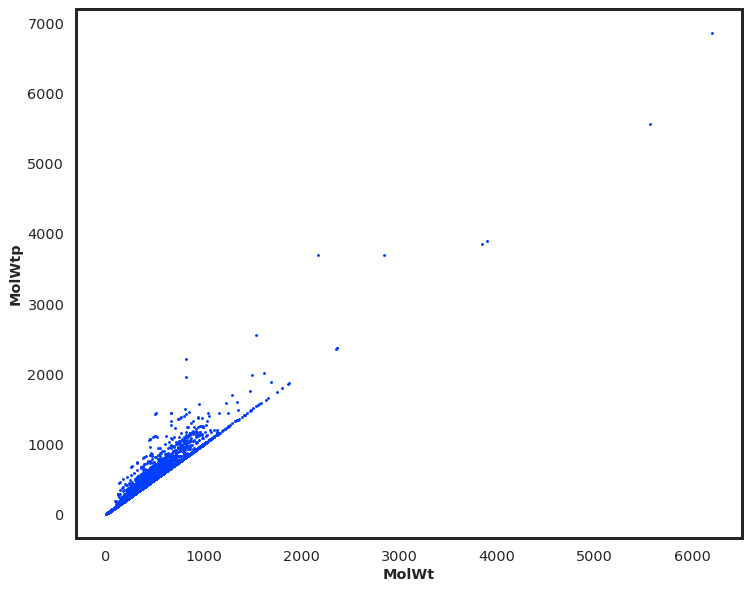

In [36]:
df.plot.scatter(x='MolWt', y='MolWtp',s=2)

In [37]:
import seaborn as sns

/tmp/ipykernel_43940/1372209034.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MolWtdiff'].values[:])


<Axes: ylabel='Density'>

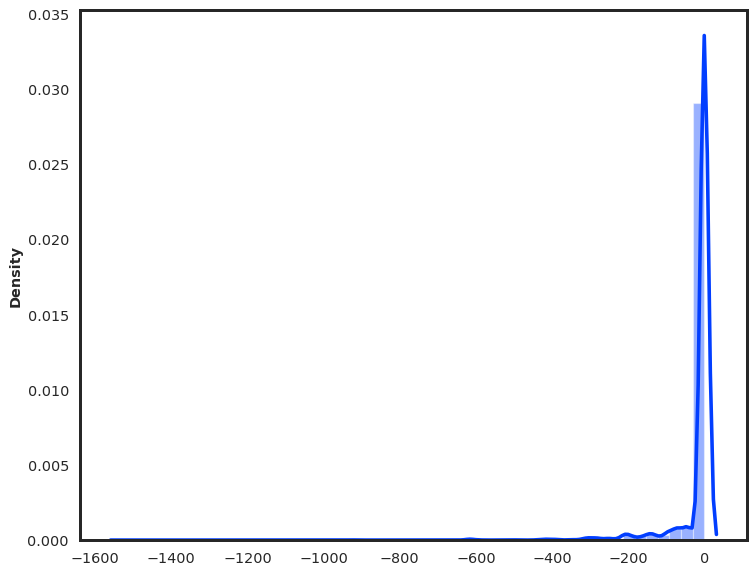

In [38]:
sns.distplot(df['MolWtdiff'].values[:])

In [39]:
df['gapdft']=df['lumo_dft']-df['homo_dft']
#dfzi.homo_z= dfzi.homo_z.apply(float)
#dfzi['gapz']=dfzi['lumo_z']-dfzi['homo_z']
#dfzi['gapmopac']=dfzi['lumo_mopac']-dfzi['homo_mopac']

In [40]:
df.homo_z = dfc.homo_z.apply(float)
df['gapz'] = df['lumo_z'] - df['homo_z']

NameError: name 'dfc' is not defined

In [41]:
df['gapmopac']=df['lumo_mopac']-df['homo_mopac']

In [42]:
df.to_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl')
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))

Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'mol', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'molp', 'MolWt', 'MolWtp', 'MolWtdiff', 'gapdft', 'gapmopac']
Table Shape: (9870, 53)
